In [ ]:
#| hide
# Use this cell only in google colab 
#! pip install git+https://github.com/BorjaRequena/Neural-Network-Course.git
#! pip install nbdev

In [ ]:
#| hide
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import plotly.express as px
import plotly.graph_objs as go
from plotly.subplots import make_subplots
from numpy.polynomial.polynomial import polyfit
from sklearn import linear_model

from lectures_ml.data_gen import curve, noisy_curve
from lectures_ml.optimizers import sgd
from lectures_ml.losses import MSE, grad_MSE_pr
from lectures_ml.utils import show_code
from nbdev.showdoc import show_doc

<a href="https://githubtocolab.com/BorjaRequena/Neural-Network-Course/blob/master/lecture_nbs/01_polynomial_fit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab"/></a>

# Fitting a noisy polynomial curve

We now consider the task of fitting a polynomial curve with noise. Despite dealing with higher order polynomials than before, this problem can also be rewritten as a linear regression task. Let us first generate a dataset with the help of the function `noisy_curve`, which maps $x$ to a polynomial of degree $d$ $f(x)=\mathbf{w}^T\mathbf{x}+\text{noise}$ and where $\mathbf{x}=(x^0,x^1,\ldots,x^d)$.

In [ ]:
coeffs = [2, 1., 0,1]
x, y = noisy_curve(coeffs, interval = [-3,1.5], noise=[0.,2])

@fig-parabola shows the generated data with the ground truth.

In [ ]:
#| label: fig-parabola
#| fig-cap: Parabola with Gaussian noise
#| code-fold: true

fig = go.Figure()
fig.add_scatter(x=x, y=y, mode="markers", name='data',
                hovertemplate='x:%{x:.2f}'
                +'<br>y:%{y:.2f}</br><extra></extra>')
x1 = np.linspace(x.min(),x.max(),num=50)
x1, y1 = noisy_curve(coeffs,x=x1)
fig.add_scatter(x=x1, y=y1, mode="lines",name='Ground Truth')
fig.update_layout(width=800,height=400,xaxis_title='x',yaxis_title='f(x)')
fig.show()

As in the previous section, we choose the mean square error for the loss function.

# Polynomial fit as multivariable linear regression

The polynomial regression can be seen as a linear regression of multiple variables with the help of the following trick. Let us rewrite $f(x)=\sum_{i=0}^d w_i x^i$ as $f(x)=\mathbf{w}^T\mathbf{x}$, where $\mathbf{x}=(x^0, x^1, \ldots, x^d)$. We can then see the polynomial fit as a linear regression of the fucntion $y=\sum_{i=0}^dw_i x_i$, where $x_i=x^i$.

The mean square error function therefore reads 

\begin{aligned}
MSE &= \sum_{i=1}^N (\mathbf{w}^T\mathbf{x}_i-y_i)^2\\
&= \parallel \mathbf{y}-X\mathbf{w}\parallel^2\\
&=(\mathbf{y}-X\mathbf{w})^T(\mathbf{y}-X\mathbf{w}),
\end{aligned}

where 

$$ X= 
\begin{pmatrix}
1 & x_1^1 & \ldots & x_1^d\\
1 & x_2^1 & \ldots & x_2^d \\
\vdots& \vdots & \vdots & \vdots\\
1 & x_N^1 & \ldots & x_N^d
\end{pmatrix} .$$

We now take the derivative with respect to all the weights $w$ and set it to $0$. We therefore find the estimator 

$$w_\text{best} =(X^TX)^{-1}X^T\mathbf{y}.$$

::: {.callout-tip}
## Exercise
Implement a `exact_poly_fit(x, y, degree)` that numerically computes the weights `w` with the expression above. You can use `np.linalg.inv` to do the matrix inversion. 
:::

In [ ]:
def exact_poly_fit(x,y,degree):
    ### YOUR CODE HERE ###

    return w

Let us run the algorithm for our dataset. We will fit a 3rd degree polynomial and compare the resulting parameters to the original ones.

In [ ]:
w_best = exact_poly_fit(x,y,3)
p1, p2 = dict(coeffs=w_best), dict(coeffs=coeffs)
print (np.array([w_best,coeffs]))
print (f'Best parameters: {MSE(x,y,curve,params=p1):.3f}','\n',f'Original parameters: {MSE(x,y,curve,params=p2):.3f}')

[[1.98070753 1.49914415 0.29703696 1.03187147]
 [2.         1.         0.         1.        ]]
Best parameters: 3.450 
 Original parameters: 3.646


The algorithm does a fairly good job. It is quite interesting to have a look at the mean square error on this dataset. The best parameters have a lower loss than the actual true parameters! We will come back to this point later ;)

# Stochastic Gradient Descent

Just like we did with the linear regression, we can optimize our model parameters with a gradient-based method. Let us see what we obtain with the stochastic gradient descent algorithm for the poynomial fit. @fig-fit shows the fit after optimization.

In [ ]:
coeffs0 = np.random.normal(loc=0,scale=0.1,size=4)

ll = dict(loss=MSE, grads=grad_MSE_pr, fun=curve)

pini = dict(coeffs=coeffs0)

df = pd.DataFrame(columns=['coeffs','value'])

trackers = sgd(x,y, pini, ll, eta=1E-5, niter=int(1E4))
df1 = pd.DataFrame(data={'coeffs':trackers['coeffs'],'value':trackers['loss']})
df = pd.concat([df, df1])

print(f'final Loss:{df["value"].iloc[-1]:3f}')
print (df["coeffs"].iloc[-1])
print(coeffs)

final Loss:3.772635
[1.1030417  0.82026664 0.76012506 1.2678085 ]
[2, 1.0, 0, 1]


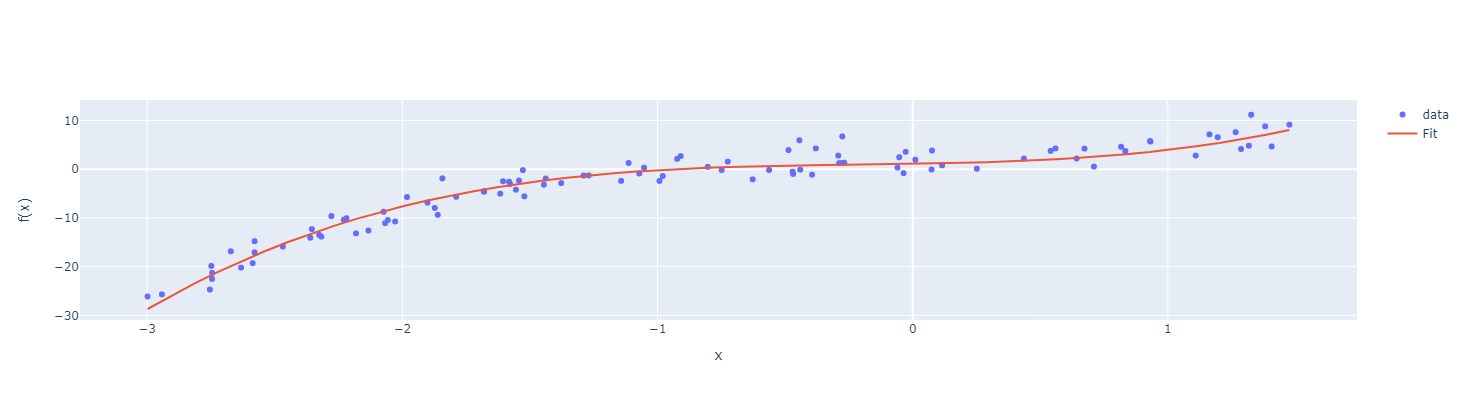

In [ ]:
#| label: fig-fit
#| fig-cap: Polynomial fit of the data
#| code-fold: true

cc = df["coeffs"].iloc[-1]

fig = go.Figure()
fig.add_scatter(x=x, y=y, mode="markers", name='data',
                hovertemplate='x:%{x:.2f}'
                +'<br>y:%{y:.2f}</br><extra></extra>')
x1 = np.linspace(x.min(),x.max(),num=50)
y1 = curve(x1,cc)
fig.add_scatter(x=x1, y=y1, mode="lines",name='Fit')
fig.update_layout(width=800,height=400,xaxis_title='x',yaxis_title='f(x)')
fig.show()

@fit_anim shows how the algotihmn adjusts the polynomial curve during the optimization.

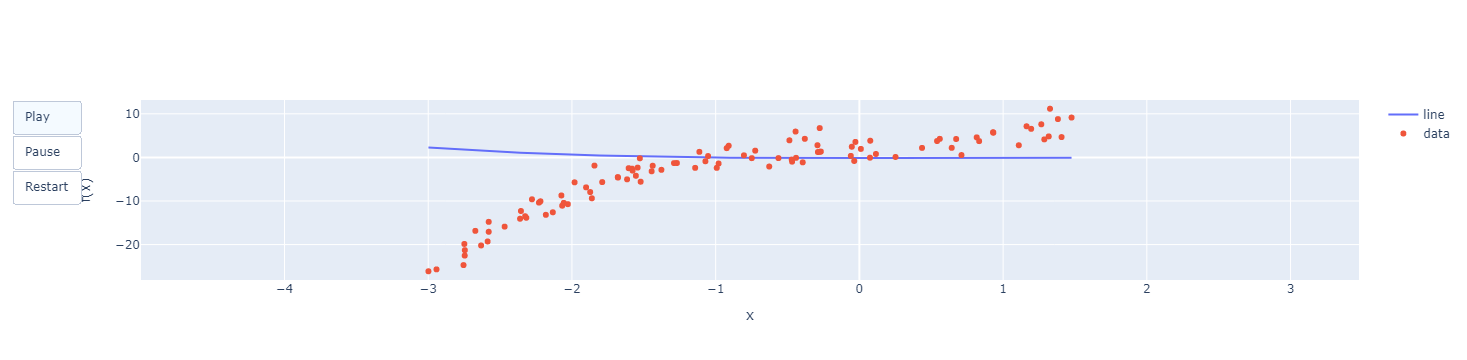

In [ ]:
#| label: fig-fitanim
#| fig-cap: Animation of the optimization
#| code-fold: true

step = 100
x1 = np.linspace(x.min(),x.max(),num=50)

frames = [go.Frame(data=[go.Scatter(x=x1, y=curve(x1,df["coeffs"].iloc[i*step]),mode='lines')],layout=go.Layout(title_text=f'step:{i*step}, MSE:{df["value"].iloc[i*step]:.2f}')) for i in range(len(df)//step)]

buttons = [dict(label="Play",method="animate",
                args=[None, {"frame": {"duration": 100, "redraw": True},
                             "fromcurrent": True, 
                             "transition": {"duration": 300,"easing": "quadratic-in-out"}}]),
           dict(label="Pause",method="animate",
                args=[[None], {"frame": {"duration": 0, "redraw": False},"mode": "immediate","transition": {"duration": 0}}]),
          dict(label="Restart",method="animate",
                args=[None,{"frame": {"duration": 100, "redraw": True}}])]

Fig = go.Figure(
    data=[go.Scatter(x=x1, y= curve(x1,df["coeffs"].iloc[0]),mode='lines',name = 'line',
                     hovertemplate='x:%{x:.2f}'+'<br>y:%{y:.2f}</br><extra></extra>'),
          go.Scatter(x=x, y=y, mode="markers", name='data',
                hovertemplate='x:%{x:.2f}'
                +'<br>y:%{y:.2f}</br><extra></extra>')],
    layout=go.Layout(
        xaxis=dict(range=[x.min()-2, x.max()+2], autorange=False),       
        yaxis=dict(range=[y.min()-2, y.max()+2], autorange=False),
        updatemenus=[dict(
            type="buttons",
            buttons=buttons)]
    ),
    frames= frames
)
Fig.update_layout(xaxis_title='x',yaxis_title='f(x)')
Fig.show()

# Overfitting

Up until now, we have not discussed a very important hyper-parameter in this problem: the degree of the polynomail. In particular, we have fixed the degree to be the one of the original function. However, this is typically unknown in practice and we either rely on educated guesses or we resort to perform various fits for different degrees and keep the best one (but what is the best one?! We'll see). To this end, we use the `polyfit` subroutine of numpy, which is much more stable than the `exact_poly_fit` we prepared.

In [ ]:
vec_cc = []
mse_t = []
mse_v = []

npoly = 20
ndata = 50
for i in np.arange(1,npoly):
    vec_cc.append(polyfit(x[:ndata],y[:ndata],deg=i))
    p1, p2 = dict(coeffs=vec_cc[i-1]), dict(coeffs=vec_cc[i-1])
    mse_t.append(MSE(x[:ndata], y[:ndata],curve,params=p1))
    mse_v.append(MSE(x[ndata:], y[ndata:],curve,params=p2))

@fig-overfitting shows the loss function over the training data as function of the polynomial degree. At a first glance, it looks like a higher degree gives rise to better loss. However, in @fig-plotoverfitting, we can really see the overfitting of the higher order polynomials. This can be detected by dividing the training set into two subsets: the training set and the *validation* set. We train the algorithm using data exclusively from the training set and, then, we evaluate its performance on the validation set. The validation set contains new data for our model, which allows us to assess how well our algorithm generalizes to unseen data. We can see that we are overfitting to the training set when we see that the loss in the validation set stagnates or increases. Turn on the orange line in @fig-overfitting to see it!

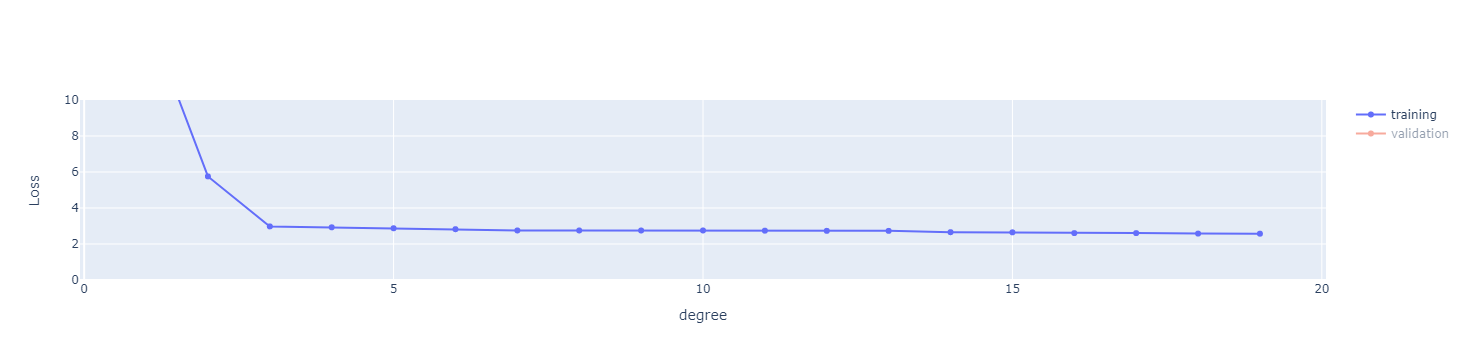

In [ ]:
#| label: fig-overfitting
#| fig-cap: Training loss with respect to the degree of the polynomial
#| code-fold: true
fig = go.Figure()
fig.add_scatter(x=np.arange(1,npoly), y=mse_t, mode='lines+markers', name='training')
fig.add_scatter(x=np.arange(1,npoly), y=mse_v, mode='lines+markers', visible='legendonly', name='validation')
fig.update_layout(yaxis_range=[0,10],xaxis_title='degree',yaxis_title='Loss')

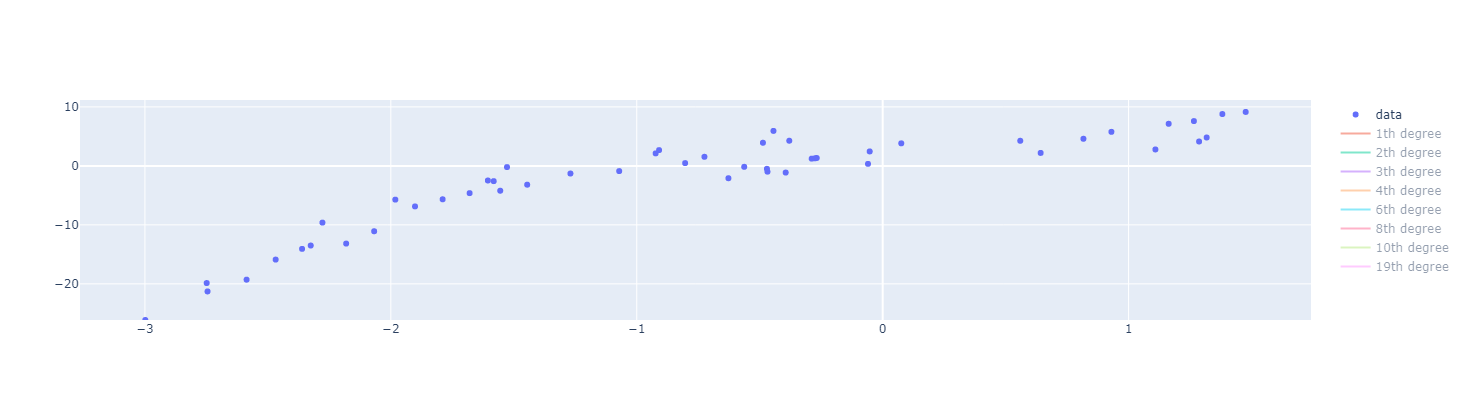

In [ ]:
#| label: fig-plotoverfitting
#| fig-cap: Training loss with respect to the degree of the polynomial
#| code-fold: true
fig = go.Figure()
fig.add_scatter(x=x[:ndata], y=y[:ndata], mode="markers", name='data',
                hovertemplate='x:%{x:.2f}'
                +'<br>y:%{y:.2f}</br><extra></extra>')
x1 = np.linspace(x.min(),x.max(),num=50)

poly = [1, 2, 3, 4, 6, 8, 10, 19]
for i,k in enumerate(poly):
    visible = True if k == 0 else 'legendonly'
    x1, y1 = noisy_curve(vec_cc[k-1],x=x1)
    fig.add_scatter(x=x1, y=y1, mode="lines",name=f'{k}th degree', visible=visible)
fig.update_layout(width=800, height=400, yaxis_range=[y.min(),y.max()])
fig.show()

A typical instance for overfitting appears when we have many free parameters compared to the number of data points. Indeed, we can achieve a zero training loss with some algorithms when we have as many parameters as data points. However, this usually comes at the expense of extreme overfitting and poor generalization.

## Exercise
In the experiment above, we have used 50 data points to fit up to a 19th-degree polynomial. Run the same procedure with increasingly less data, e.g., set `ndata` to 30, 20 and 10, and observe what happens with the resulting curves. Do we see overfitting for lower degree polynomials? Do you think these models would provide a reasonable prediction if we drew a new data sample form the same experiment? 

We will now discuss two strategies to prevent overfitting.

# More data
As we have seen right above, the relative number of our model parameters compared to the amount of data that we have is a key factor for overfitting. If having less data makes our model more prone to overfitting, having more data naturally helps us mitigate it. 

In [ ]:
nsamples = int(1E3)
xn, yn = noisy_curve(coeffs, interval = [-3,1.5], noise=[0.,2], nsamples=nsamples)

In [ ]:
vec_cc = []
mse_t = []
mse_v = []

npoly = 20
ndata = int(0.8*nsamples)

for i in np.arange(1,npoly):
    vec_cc.append(polyfit(xn[:ndata],yn[:ndata],deg=i))
    mse_t.append(MSE(xn[:ndata], yn[:ndata],vec_cc[i-1]))
    mse_v.append(MSE(xn[ndata:], yn[ndata:],vec_cc[i-1]))

In [ ]:
fig = go.Figure()
fig.add_scatter(x=np.arange(1,npoly), y=mse_t, mode='lines+markers', name='training')
fig.add_scatter(x=np.arange(1,npoly), y=mse_v, mode='lines+markers', visible='legendonly', name='validation')
fig.update_layout(yaxis_range=[0,10])

In [ ]:
fig = go.Figure()
fig.add_scatter(x=xn[:ndata], y=yn[:ndata], mode="markers", name='data',
                hovertemplate='x:%{x:.2f}'
                +'<br>y:%{y:.2f}</br><extra></extra>')
x1 = np.linspace(x.min(),x.max(),num=50)

poly = [1, 2, 3, 4, 6, 8, 10, 19]
for i,k in enumerate(poly):
    visible = True if k == 0 else 'legendonly'
    x1, y1 = noisy_curve(vec_cc[k-1],x=x1)
    fig.add_scatter(x=x1, y=y1, mode="lines",name=f'{k}th degree', visible=visible)
fig.update_layout(width=800, height=400, yaxis_range=[y.min(),y.max()])
fig.show()

# Regularization

In [ ]:
def poly_cond(x, n):
    matx = np.zeros((x.size,n))
    for i,k in enumerate(range(1,n+1)):
        matx[:,i] = x**k
    return matx

In [ ]:
#| output: false
vec_cc = []
mse_t = []
mse_v = []

npoly = 20
ndata = 50
for i in np.arange(1,npoly):
    matx = poly_cond(x[:ndata],i)
    reg = linear_model.Ridge(alpha=0.5)
    reg.fit(matx,y[:ndata])
    c = np.insert(reg.coef_,0,reg.intercept_)
    vec_cc.append(c)
    mse_t.append(MSE(x[:ndata], y[:ndata],vec_cc[i-1]))
    mse_v.append(MSE(x[ndata:], y[ndata:],vec_cc[i-1]))

In [ ]:
fig = go.Figure()
fig.add_scatter(x=np.arange(1,npoly), y=mse_t, mode='lines+markers', name='training')
fig.add_scatter(x=np.arange(1,npoly), y=mse_v, mode='lines+markers', visible='legendonly', name='validation')
fig.update_layout(yaxis_range=[0,10])

In [ ]:
fig = go.Figure()
fig.add_scatter(x=x[:ndata], y=y[:ndata], mode="markers", name='data',
                hovertemplate='x:%{x:.2f}'
                +'<br>y:%{y:.2f}</br><extra></extra>')
x1 = np.linspace(x.min(),x.max(),num=50)

poly = [1, 2, 3, 4, 6, 8, 10, 19]
for i,k in enumerate(poly):
    visible = True if k == 0 else 'legendonly'
    x1, y1 = noisy_curve(vec_cc[k-1],x=x1)
    fig.add_scatter(x=x1, y=y1, mode="lines",name=f'{k}th degree', visible=visible)
fig.update_layout(width=800, height=400, yaxis_range=[y.min(),y.max()])
fig.show()